In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install git+https://github.com/mwaskom/seaborn.git

  Preparing metadata (setup.py) ... done
  Cloning https://github.com/mwaskom/seaborn.git to /tmp/pip-req-build-zp25t4ay
  Running command git clone --filter=blob:none --quiet https://github.com/mwaskom/seaborn.git /tmp/pip-req-build-zp25t4ay
  Resolved https://github.com/mwaskom/seaborn.git to commit 2c2c84e8c5d8fe8ef6b00da5bd47a54c8f5f08da
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seaborn: filename=seaborn-0.14.0.dev0-py3-none-any.whl size=294636 sha256=be1519e1136ce47997a580eee4e3c0067d2d2946133b494404cd314a610e7ecf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ba_51p95/wheels/3c/62/67/77ea88d32d3804d549b08f4c1e9cd0bcfbf53c42cd6b0f8f03
Successfully built seaborn
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
import sys
import json
import pandas as pd
import numpyro
import arviz as az

sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/preprocessing/')
sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/viz/')
sys.path.append('drive/MyDrive/user-mod-alignment/policy_analysis/models/')

Mounted at /content/drive/


In [3]:
from preprocess_support import load_population_participation
from preprocess_awareness import load_awareness


#Preprocessing Data#

#### Load in survey response data from awareness.json. This includes adjustment variables for MRP   ####



In [5]:
pop_df = load_population_participation("/content/drive/My Drive/user-mod-alignment/population_participation.json")
response_df, participation_df, id2rule = load_awareness("/content/drive/My Drive/user-mod-alignment/policy_awareness.json")

Fake Rule (Invalidation)
Fake Rule (Medical Advice)
Fake Rule (Cite Sources)
Fake Rule (Replies to Removals)
Fake Rule (Information Quality)


# MRP Adjusted Policy-Awareness Model #

#### This model is described in section 4.3.1 and A.1 of the main paper. ####

In [ ]:
from awareness_adj import run_model
cor_model, means, stds = run_model(participation_df, response_df)
inf_data = az.from_numpyro(cor_model)

sample: 100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s, 511 steps of size 9.96e-03. acc. prob=0.95]


In [ ]:
pd.options.display.max_rows = 4000
print(az.summary(inf_data, var_names=["base_slope",
                                      "com_gen_slope", "com_sub_slope", "rem_sub_slope", "rem_gen_slope",
                                      "age_slope", "mod_slope_0", "mod_slope_1"]))


Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
base_slope[0]      1.695  0.799   0.361    3.246      0.034    0.024   
base_slope[1]      0.931  0.759  -0.520    2.278      0.035    0.025   
base_slope[2]      0.833  0.824  -0.773    2.327      0.041    0.031   
base_slope[3]      1.831  0.862   0.384    3.487      0.042    0.029   
base_slope[4]      1.047  0.866  -0.374    2.734      0.037    0.030   
base_slope[5]     -0.679  0.780  -2.160    0.802      0.033    0.026   
base_slope[6]     -0.098  0.811  -1.762    1.268      0.036    0.036   
base_slope[7]     -1.052  0.893  -2.923    0.378      0.040    0.029   
base_slope[8]     -0.683  0.889  -2.501    0.822      0.039    0.035   
base_slope[9]     -0.477  0.848  -1.902    1.136      0.040    0.033   
com_gen_slope[0]  -0.006  0.017  -0.041    0.021      0.001    0.001   
com_gen_slope[1]   0.006  0.014  -0.019    0.032      0.001    0.001   
com_gen_slope[2]   0.024  0.014  -0.002    0.046      0.001    0

# Post-stratification #

### Applies fitted model to target population we want to generalize to in order to correct for response bias. Note that to do this we need to have a sample of our adjustment variables in the population we want to generalized to. Here, we load into pop_df a sample of these variables for ~1200 users who received a survey link, regardless of whether they responded or not. ###

In [ ]:
from preprocess_support import standardize_pop_df

user_scraped = participation_df[participation_df["self_report"] == False].copy()
decision_dataset = response_df.join(user_scraped ,on="user", how="inner")
standardized_pop_df = standardize_pop_df(pop_df, means, stds)

In [ ]:
print(user_scraped.rem_gen.values[:20])
print(standardized_pop_df.rem_gen.values[:20])

[1.791759469228055 1.6094379124341003 1.791759469228055 1.6094379124341003
 0.0 0.6931471805599453 0.0 0.0 0.6931471805599453 0.0 0.0
 1.0986122886681098 2.4849066497880004 0.0 0.0 1.0986122886681098
 0.6931471805599453 0.6931471805599453 0.6931471805599453 0.0]
[0.93639016 0.93639016 0.93639016 0.93639016 0.93639016 1.20645594
 1.20645594 1.20645594 1.20645594 1.20645594 0.09748923 0.09748923
 0.09748923 0.09748923 0.09748923 1.20645594 1.20645594 1.20645594
 1.20645594 1.20645594]


In [ ]:
from awareness_adj import posterior_predictions

gt_proportions, predicted_proportions = posterior_predictions(cor_model, decision_dataset, standardized_pop_df)
print(predicted_proportions)

(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
(500, 6380)
[Array([0.90172414, 0.93652038, 0.90971787, 0.919279  , 0.92915361,
       0.9015674 , 0.92931034, 0.92445141, 0.90909091, 0.92445141,
       0.93134796, 0.92163009, 0.92821317, 0.93526646, 0.89952978,
       0.91865204, 0.8976489 , 0.92617555, 0.93056426, 0.92774295,
       0.90987461, 0.91833856, 0.91708464, 0.90893417, 0.9161442 ,
       0.90893417, 0.94106583, 0.91974922, 0.91081505, 0.92021944,
       0.93354232, 0.92178683, 0.91112853, 0.91677116, 0.91520376,
       0.90438871, 0.92617555, 0.9039185 , 0.93197492, 0.91159875,
       0.92351097, 0.90877743, 0.92115987, 0.92586207, 0.91316614,
       0.90297806, 0.89278997, 0.91175549, 0.90768025, 0.93181818,
       0.93714734, 0.91003135, 0.91959248, 0.92319749, 0.9177116 ,
       0.91410658, 0.92884013, 0.93369906, 0.93934169, 0.91833856,
       0.9177116 , 0.91018809, 0.91347962, 0.91786834, 0.919279  ,
       0

#### Generates figure in A.1.2 in the main paper. ####

500


/content/drive/MyDrive/user-mod-alignment/policy_analysis/viz/awareness_viz.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


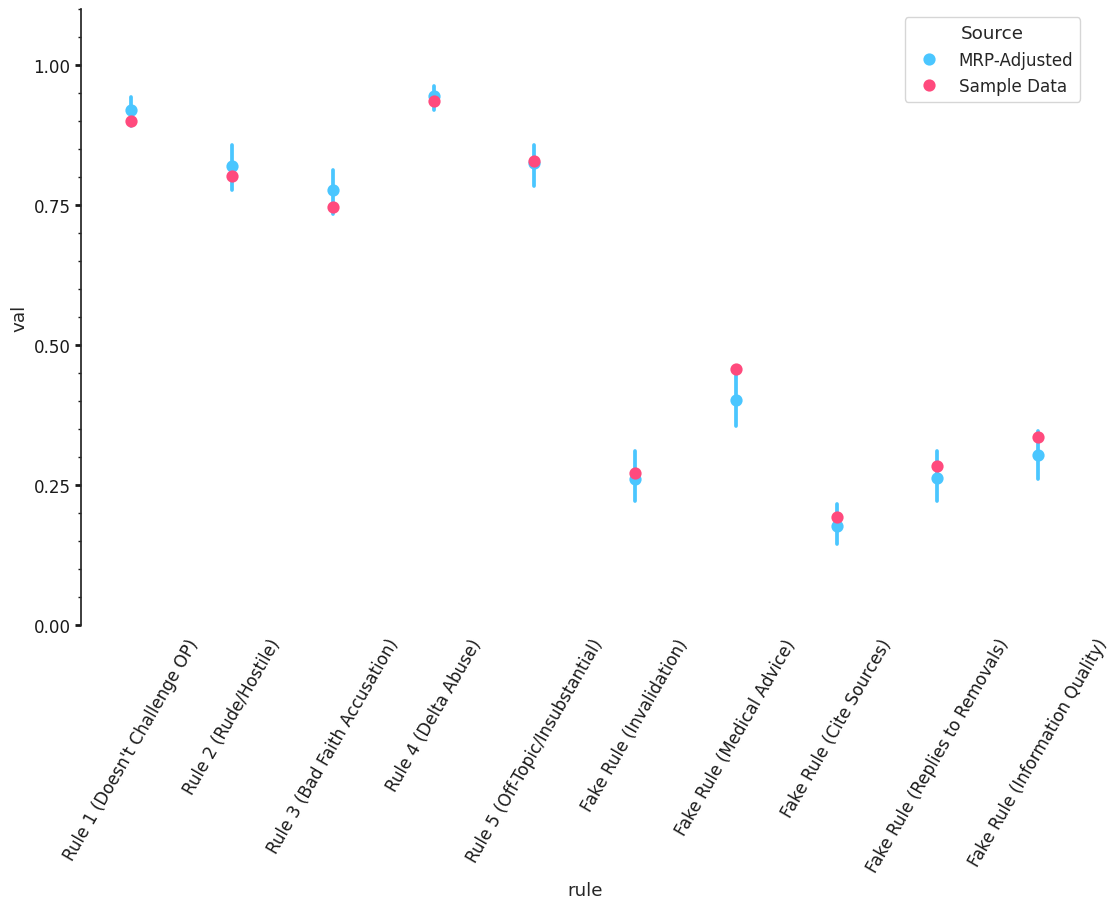

In [ ]:
from awareness_viz import plot_posterior_predictions, plot_participation
print(len(predicted_proportions[0]))
plot_posterior_predictions("/content/mrp-adjusted-awareness.pdf", gt_proportions, predicted_proportions, id2rule)

### Generates figure 4 in the main paper. ###

/content/drive/MyDrive/user-mod-alignment/policy_analysis/viz/awareness_viz.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(["Not a Mod", "Is a Mod"])


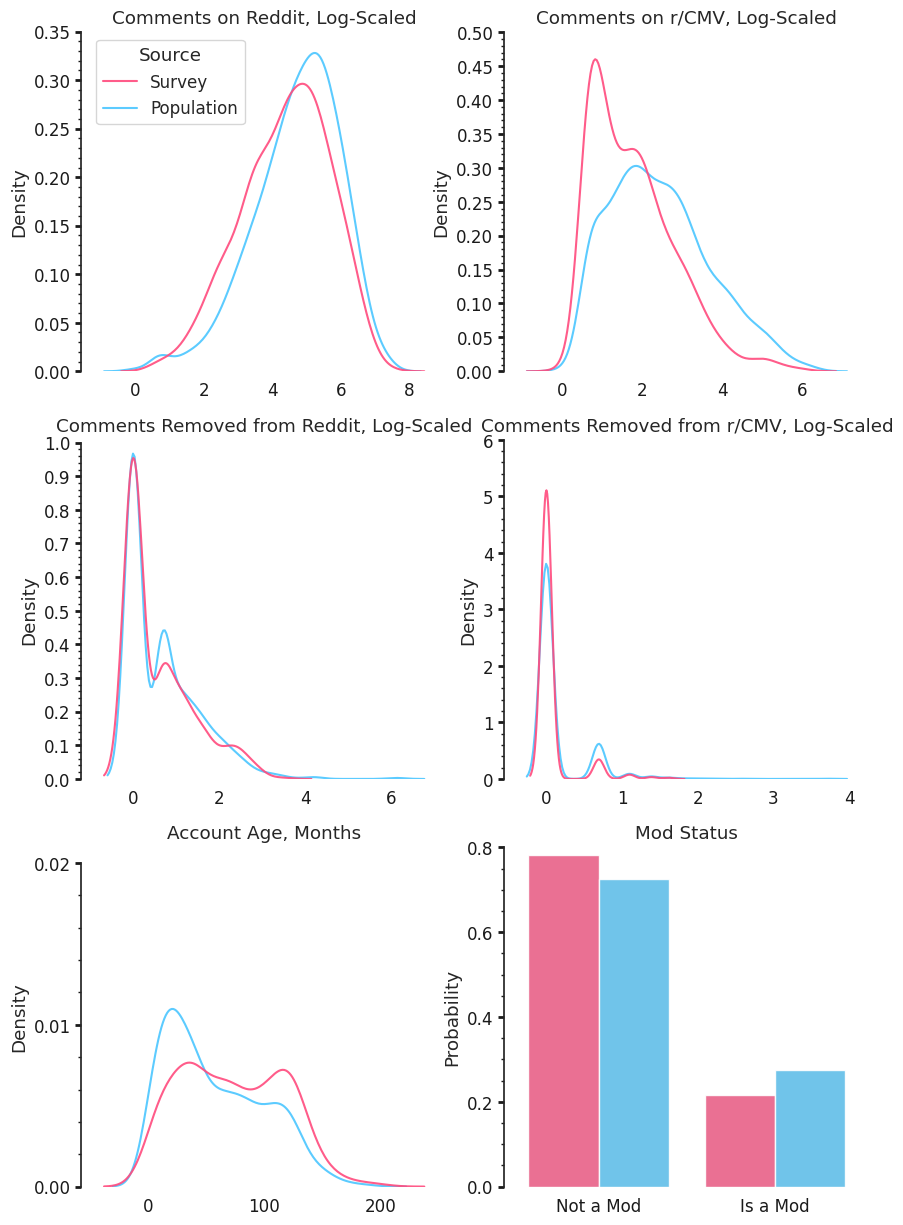

In [ ]:
import numpy as np

#reload in participation df with only com_gen and com_sub log-scaled
_, participation_df, _ = load_awareness("/content/drive/My Drive/user-mod-alignment/awareness.json", log_scale = ["com_gen", "com_sub", "rem_gen", "rem_sub"])
pop_df = load_population_participation("/content/drive/My Drive/user-mod-alignment/population_participation.json", log_scale = ["com_gen", "com_sub", "rem_gen", "rem_sub"]) #only log scale com_gen and com_sub for these plots
pop_df = pop_df[pop_df["rule"] == 0] #remove duplicates
pop_df["age"] = pop_df["age"].astype(float) / (60*60*24*(365)/12) # convert population ages from seconds to months
scraped = participation_df[participation_df["self_report"] == False]
scraped["age"] = scraped["age"].astype(float) / (60*60*24*(365)/12)
scraped = scraped.drop(scraped['rem_gen'].astype(int).idxmax())
all_participation_df = plot_participation("/content/participation-rates.pdf", pop_df, scraped)

In [ ]:
#undo log_scaling to commute raw median values
all_participation_df["com_gen"] = np.exp(all_participation_df["com_gen"].astype(float)) - 1
all_participation_df["com_sub"] = np.exp(all_participation_df["com_sub"].astype(float)) - 1
all_participation_df["rem_gen"] = np.exp(all_participation_df["rem_gen"].astype(float)) - 1
all_participation_df["rem_sub"] = np.exp(all_participation_df["rem_sub"].astype(float)) - 1


In [ ]:
print("Median monthly comments (Survey)", all_participation_df[all_participation_df["Source"] == "Survey"].com_gen.median())
print("Median monthly comments (Population)", all_participation_df[all_participation_df["Source"] == "Population"].com_gen.median())

Median monthly comments (Survey) 87.99999999999999
Median monthly comments (Population) 130.99999999999997


In [ ]:
print("Median monthly CMV comments (Survey)", all_participation_df[all_participation_df["Source"] == "Survey"].com_sub.median())
print("Median monthly CMV comments (Population)", all_participation_df[all_participation_df["Source"] == "Population"].com_sub.median())

Median monthly CMV comments (Survey) 3.999999999999999
Median monthly CMV comments (Population) 9.000000000000002


In [ ]:
print("Median removed monthly comments (Survey)", all_participation_df[all_participation_df["Source"] == "Survey"].rem_gen.median())
print("Median removed monthly omments (Population)", all_participation_df[all_participation_df["Source"] == "Population"].rem_gen.median())

Median removed monthly comments (Survey) 0.0
Median removed monthly omments (Population) 1.0


In [ ]:
print("Median removed monthly CMV comments (Survey)", all_participation_df[all_participation_df["Source"] == "Survey"].rem_sub.median())
print("Median removed monthly CMV omments (Population)", all_participation_df[all_participation_df["Source"] == "Population"].rem_sub.median())

Median removed monthly CMV comments (Survey) 0.0
Median removed monthly CMV omments (Population) 0.0


In [ ]:
print("Median age", all_participation_df[all_participation_df["Source"] == "Survey"].age.median())
print("Median age", all_participation_df[all_participation_df["Source"] == "Population"].age.median())

Median age 69.98487582285401
Median age 47.262603224874226
